# Raw Asif Dataset

The objective of this notebook is to perfom a first cleaning of the dataset and save it to CSV.

The raw data is a large Stata file. About 1.2gb, for year 1998 to 2007. 

Note that, the raw dataset is saved in Stata 13. There is no way to read the chinese encoding. The variables 
`product1_`, `village`, `street`,`town`, `legal_person` are loaded but all gibberish.

Variables: 

From [Brandt paper- Challenges of working with the Chinese NBS firm-level data](https://docs.google.com/file/d/16agSbxO7cYuEn1v2bvw16ZRAx9gg7-Zm/edit)

Online files are availble [here](https://feb.kuleuven.be/public/u0044468//CHINA/appendix/)

![table2.png](https://dynalist.io/u/gN4m5XOn0VjotFYpiuWkrJ_d)

Variables kept: 

|  Brands          | 2008       | 2009               | Label           |
| ---------------- | ---------- | ------------------ |------------------
| bdat             | 开业(成立)时间--年       | 开业(成立)时间--年        | Birth date|
| cic              | 行业代码        | 行业代码               | Industrial 2 digits codes|
| dq               | 新行政代码 (6 digits)        |                    | City code, large number of digits |
| e_HMT            | 登记注册类型 | -                  | share HTM in equity |
| e_collective     | 登记注册类型        | -                  |share collective in equity|
| e_foreign        | 登记注册类型        | -                  |share foreign in equity|
| e_individual     | 登记注册类型        | -                  |share individual in equity|
| e_legal_person   | 登记注册类型        | -                  |share legal persone in equity|
| e_state          | 登记注册类型        | -                  |share state in equity|
| employment       | 全部从业人员年平均人数      | 全部从业人员年平均人数        | employement, in XX|
| export           | 出口交货值        | 出口交货值              | Export, in XX|
| fa_net           | 固定资产合计         |                    | Net fixed asset, in XX|
| fa_original      |            |                    |Original fixed asset, in XX |
| a_dep            |            |                    |Amortization|
| c_dep            |            |                    |Depreciation|
| id               | B00        | 法人代码               |Firm ID|
| input            |            |                    |Input, in XX|
| legal_person     | B03        |                    |Legal person|
| name             | 法人单位    |                    |Company's name|
| new_product      |            |                    |??|
| output           | 工业总产值（当年价格）        | 工业总产值(当年价格)        |Industrial output, in XX|
| phone            | 电话号码       | 电话号码               |Phone number|
| product1_        |  主营产品1          |                    |??|
| profit           | 营业利润       | 营业利润               |Profit, in XX|
| revenue          | 主营业务收入       | 主营业务收入             |Revenue, in XX|
| street           | 街道办事处       | 街道办事处              |Street name|
| town             | 乡（镇）       | 乡（镇）               |Town name|
| type             | 登记注册类型        | 登记注册类型             |Company's type|
| va               | V08 - OS06 | 工业总产值(当年价格) - 营业费用 |Value added|
| village          | 街（村）、门牌号       | 街（村）、门牌号           |Village name|
| wage             |        |                    |Wage, in XX|
| zip              | 邮政编码       | 邮政编码               |Zip Code|
|citycode |citycode | citycode| First four digits of `dq`|

Note `va` is excluded since we don't have the variable to compute it

## Steps

### Step 1: 

- Read stata file in batch of 100000 rows at a time

### Step 2:

- change lower case to upper case in "firm id"

### Step 3:

- Clean bdat: birthdate/ zip and Phone
    - There are non numeric observation. They are changed to NaN
    - For bdat:
        - Change to NaN all year lower than 999
    
### Step 4:

- Create citycode and clean it
    - citycode is first four digit of `dq`
    - Remove all non numeric observations
    - Remove all observation with less than 4 digits
    
### Step 5

- Remove all observation for type with less than 2 digits and more than 3 digit

In 2008, about 212 observations have more than 3 digits

### Step 6

- Remove all non numeric output: about 279092

### Step 7: Compute Value added: EXCLUDED

$va  = output - input + vaaddtax$

### Step 8

- deal with duplicates of IDs (there are a few firms that have same IDs)


In [8]:
import pandas as pd
import numpy as np
import tqdm
import time
from Fast_connectCloud import connector
from GoogleDrivePy.google_platform import connect_cloud_platform

In [2]:
gs = connector.open_connection(online_connection = False, 
	path_credential = '/Users/Thomas/Google Drive/Projects/Data_science/Google_code_n_Oauth/Client_Oauth/Google_auth/')

service_gcp = gs.connect_remote(engine = 'GCP')

project = 'valid-pagoda-132423'
gcp = connect_cloud_platform.connect_console(project = project,
											 service_account = service_gcp['GoogleCloudP'])

Service account storage and Bigquery are now connected. 
Service account storage is stored as <google.cloud.storage.client.Client object at 0x121e8a510> and accessible with "Storage_account" 
Service account Bigquery is stored as <google.cloud.bigquery.client.Client object at 0x121e8aad0> and accessible with "bigquery_account"


## Wrap up function

Recall 

```
 If ‘raise’, then invalid parsing will raise an exception
 If ‘coerce’, then invalid parsing will be set as NaN
 If ‘ignore’, then invalid parsing will return the input
```

In [3]:
def prepareData(data, dropna = True): 
    
    """
    Steps:
    1. change lower case to upper case in "firm id"
    2. bdat/zip/phone/cic: Change non numeric to nan
    3. Clean wrong date: if len year inf to 3 digits
    4. Clean wrong city: if len city inf to 4 digits
    5. Clean wrong type: if len type inf to 2 digits
    6. Remove NaN for 'id','citycode' & 'type'
   
    """
    #change lower case to upper case in "firm id"
    data['id'] = data['id'].str.upper()
    data['year'] = data['year'].astype('str')
    data['year'] = data['year'].str.split('.').str[0]
    
    #### Clean bdat/ phone and zip
    ##### Change non numeric to nan
    ##### 
    
    for n in ['bdat', 'zip', 'phone', 'cic', 'dq']:
    ### Need to do like this because 
    ### Cannot convert non-finite values (NA or inf) to integer
        index = data.columns.get_loc(n)
        data[n] = pd.to_numeric(data.iloc[:, index],
                                errors='coerce'
                               )
        data[n] = data[n].astype('str')
        data[n] = data[n].str.split('.').str[0]
        
    #### Clean wrong date: if len year inf to 3 digits, then nan
    data.loc[(data['bdat'] != np.nan) &
          (data['bdat'].astype('str').str.len() < 3),
         'code'
         ] = np.nan

    #### Deal with dq: city code
    data['citycode'] = data['dq'].str.slice(start=None, stop=4)

    #### Remove whitespace
    data['citycode']  = data['citycode'].str.replace(" ","")
    data.loc[#(data['citycode'] != np.nan) &
          data['citycode'].astype('str').str.len() < 4,
         'citycode'
         ] = np.nan
    
    #### Deal with type
    data.loc[(data['type'] != np.nan) &
            (data['type'].astype('str').str.len() < 2) |
            (data['type'].astype('str').str.len() > 3),
         'type'
         ] = np.nan
    
    if dropna:
        data = data.dropna(subset=['id','citycode', 'type', 'profit'])
    
    data = data.drop(columns =['dq', 'code'])  
    
    return data

## Download Data 1998- 2009

Note that file `stata_year_2008.csv` does not come from stata but Excel. We have two versions of year 2008.

One's come from Zhao Ruili: missing 70% of the data. Another one comes from Chen Zhao. Missing some vars and firm's ID

In [19]:
list_data = ['stata_year_1998.csv', 'stata_year_1999.csv',
                'stata_year_2000.csv', 'stata_year_2001.csv',
                'stata_year_2002.csv', 'stata_year_2003.csv',
                'stata_year_2004.csv', 'stata_year_2005.csv', 
                'stata_year_2006.csv', 'stata_year_2007.csv',
                'stata_year_2008.csv','stata_year_2009.csv'
            ]

In [5]:
for dataset in list_data:
    gcp.download_blob(bucket_name = 'chinese_data',
                  destination_blob_name = 'Panel_china/Asif_panel_china/Raw_',
                  source_file_name = dataset)

File Panel_china/Asif_panel_china/Raw_/stata_year_1998.csv uploaded locally
File Panel_china/Asif_panel_china/Raw_/stata_year_1999.csv uploaded locally
File Panel_china/Asif_panel_china/Raw_/stata_year_2000.csv uploaded locally
File Panel_china/Asif_panel_china/Raw_/stata_year_2001.csv uploaded locally
File Panel_china/Asif_panel_china/Raw_/stata_year_2002.csv uploaded locally
File Panel_china/Asif_panel_china/Raw_/stata_year_2003.csv uploaded locally
File Panel_china/Asif_panel_china/Raw_/stata_year_2004.csv uploaded locally
File Panel_china/Asif_panel_china/Raw_/stata_year_2005.csv uploaded locally
File Panel_china/Asif_panel_china/Raw_/stata_year_2006.csv uploaded locally
File Panel_china/Asif_panel_china/Raw_/stata_year_2007.csv uploaded locally


### Original data 

The original paper has the following obs before cleaning

![table1.png](https://dynalist.io/u/YV6JdMqFuJDxlg1ty2ewKi_-)

We compare the raw data we have with the raw data from the paper

1998-2007

In [9]:
df_raw = pd.DataFrame()
for year in tqdm.notebook.tqdm(range(1998, 2008, 1)):
    #print(year)
    df_ = pd.read_csv(
        'stata_year_{0}.csv'.format(year),
        usecols = ['id'],
        )
    df_['year'] = year
    
    df_raw = df_raw.append(df_, sort = False)

2008-2009

2008 does not have firm's ID

In [ ]:
df_2008 = pd.read_csv(
        'stata_year_2008.csv'.format(year),
        )
df_2008['id'] = df_2008.index
df_2008['year'] = '2008'
df_2008 = df_2008[['year', 'id']]
df_raw = df_raw.append(df_2008, sort = False)

In [ ]:
df_2009 = pd.read_csv(
        'stata_year_2009.csv'.format(year),
    usecols = ['法人代码'],
        )
df_2009['year'] = '2009'
df_2009 = df_2009.rename(columns={'法人代码': "id"})
df_raw = df_raw.append(df_2009, sort = False)

In [10]:
def compare_raw_Brandt(raw):
    """
    function to compare the raw count
    from Brandt paper
    """

    df_raw = raw.dropna(subset=["id"])
    df_raw_count = df_raw.groupby("year")["id"].count()
    
    if len(df_raw_count.index) == 10:
        s = [165118,162033,162883,169030,
             181557,196222,279092,271835,
             301961,336768,#327853,np.nan,
                    ]
    elif len(df_raw_count.index) == 11:
        s = [165118,162033,162883,169030,
             181557,196222,279092,271835,
             301961,336768,327853#,np.nan,
                    ]
    else:
        s = [165118,162033,162883,169030,
             181557,196222,279092,271835,
             301961,336768,327853,np.nan,
                    ]

    temp = (
        pd.concat(
            [
                pd.Series(
                    s
                    ,
                    index=df_raw_count.index,
                    name="Brandt",
                ),
                df_raw_count,
            ],
            axis=1,
        )
        # .reset_index()
        # .apply(lambda x: x['Brandt'] - x['id'], axis = 1)
    )
    
    temp['diff'] = temp['Brandt'] - temp['id']
    
    #temp.iloc[:,[2]].plot(kind='bar')
    
    return temp.iloc[:,:2].plot(kind='bar')

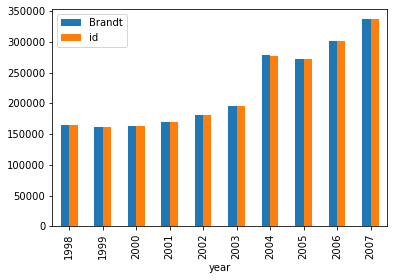

In [11]:
compare_raw_Brandt(raw= df_raw)

## Prepare Data

### 1998 - 2007 

We specify the type for each variable so that we avoid the warning `DtypeWarning: Columns (X) have mixed types.`

We load equity share, output, employement, export, fa_original, fa_net, profit a_dep, c_dep, wage, input as object because so observations have formating issue (infinity, NaN, especially for year 2005, 2006, 2007). We tackle it in the `prepareData` function.

The program runs for about 12 minutes to clean up the data

In [20]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_stata.html
list_convert = ['va','e_HMT', 'e_collective', 'e_foreign',
                'e_legal_person', 'e_state', 'e_individual',
                'employment', 'export', 'fa_net', 'fa_original',
                'a_dep', 'c_dep','input', 'output', 'profit',
                'revenue', 'wage',
                ]
dtypes = {
    'id':'str',
    'year':'str',
    'name':'str',
    'bdat':'str',
    'cic':'str',
    'dq':'str',
    'e_HMT':'str',
    'e_collective':'str',
    'e_foreign':'str',
    'e_individual':'str',
    'e_legal_person':'str',
    'e_state':'str',
    'employment':'str',
    'output':'str',
    'profit':'str',
    'revenue':'str',
    'wage':'str',
    'export':'str',
    'fa_net':'str',
    'fa_original':'str',
    'a_dep':'str',
    'c_dep':'str',
    'input':'str',
    'new_product':'str',
    'phone':'str',
    'type':'str',
    'zip':'str',
    'town':'str',
    'product1_':'str'
}

df_9807 = pd.DataFrame()

start_time = time.time()

#for chunk in progressbar.progressbar(itr):
for load in tqdm.notebook.tqdm(list_data[:-2]):
    
    df_csv = pd.read_csv(load, dtype = dtypes)
    ### Drop Value added
    #df_csv = df_csv.drop(columns = 'va')
    
    
    df_temp = prepareData(data = df_csv)    

    df_9807 = df_9807.append(df_temp, sort=False)
    
df_9807 = df_9807[df_9807['year'] != 'nan']   

print('Done Appending, begin to convert to numeric') 
shape_before = df_9807.shape[0]
list_missing = []
for name in list_convert:
    df_9807[name] = df_9807[name].apply(pd.to_numeric,
                                errors='coerce'
                             )
    
    count_missing = df_9807[name].isna().sum()
    print("Var {} has {} missing values".format(name, 
                                                count_missing)
                                                )
    
    if count_missing >0:
        list_missing.append(count_missing)
    
#df_ = df_.dropna(subset=list_missing)
shape_after = df_9807.shape[0]

dropped = shape_after - shape_after

print("""
The following variables {0} contain NaN, hence removed.
A total of {1} obs have been dropped.""".format(
    list_missing,
    dropped)
     )

#deal with duplicates of IDs (there are a few firms that have same IDs)*
df_9807 = df_9807.drop_duplicates(['year', 'id'])

print('Time elasped to prepare data 1998-2007:{0:.2f} minutes'.format(
    (time.time() - start_time)/60.0)
     )


Done Appending, begin to convert to numeric
Var va has 445502 missing values
Var e_HMT has 0 missing values
Var e_collective has 0 missing values
Var e_foreign has 0 missing values
Var e_legal_person has 0 missing values
Var e_state has 0 missing values
Var e_individual has 0 missing values
Var employment has 0 missing values
Var export has 0 missing values
Var fa_net has 0 missing values
Var fa_original has 0 missing values
Var a_dep has 0 missing values
Var c_dep has 0 missing values
Var input has 0 missing values
Var output has 0 missing values
Var profit has 0 missing values
Var revenue has 0 missing values
Var wage has 0 missing values

The following variables [445502] contain NaN, hence removed.
A total of 0 obs have been dropped.
Time elasped to prepare data 1998-2007:13.69 minutes


In [21]:
df_9807['year'].unique()

array(['1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005',
       '2006', '2007'], dtype=object)

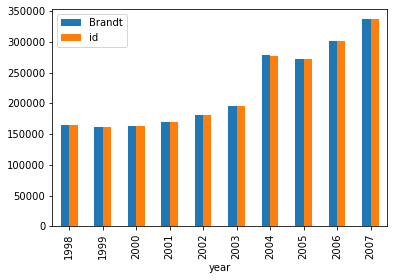

In [22]:
df_raw = df_9807[['id', 'year']]
compare_raw_Brandt(raw= df_raw)

### Original data 

The original paper has the following obs before cleaning

![table1.png](https://dynalist.io/u/YV6JdMqFuJDxlg1ty2ewKi_-)

And after matching and cleaning. Note in this notebook, we don't do the matching

![table4.png](https://dynalist.io/u/lYSk2vVt4mgp8tTzMW1khS2Y)


In [23]:
df_9807.groupby('year')['id'].count()

year
1998    165108
1999    162012
2000    162791
2001    169013
2002    181540
2003    196156
2004    276448
2005    271811
2006    301913
2007    336717
Name: id, dtype: int64

In [86]:
dic_ = {
    'year': ["1998",
             "1999",
             "2000",
             "2001",
             "2002",
             "2003",
             "2004",
             "2005",
             "2006",
             "2007"
             ],
    'count_brand':
        [165118,
         162033,
         162883,
         169030,
         181557,
         196222,
         279092,
         271835,
         301961,
         336768
         ],

    'output_brand':
    [
        6.77,
        7.27,
        8.57,
        9.41,
        11.08,
        14.23,
        20.16,
        25.16,
        31.66,
        40.52
    ],
    'va_brand':
    [
        1.94,
        2.16,
        2.54,
        2.79,
        3.30,
        4.20,
        6.62,
        7.22,
        9.11,
        11.70
    ],
    'employment_brand':
    [
        56.44,
        58.05,
        53.68,
        52.97,
        55.21,
        57.49,
        66.27,
        68.96,
        73.58,
        78.75

    ]
}
brand = pd.DataFrame(dic_).set_index('year')
brand.dtypes

count_brand           int64
output_brand        float64
va_brand            float64
employment_brand    float64
dtype: object

In [91]:
count = df_9807.groupby('year')['id'].count().rename('count')
output = (df_9807.groupby('year')['output'].sum()/ 1000000000).round(1)
va = (df_9807.groupby('year')['va'].sum()/ 1000000000).round(1)
emp = (df_9807.groupby('year')['employment'].sum()/ 1000000).round(2)

In [97]:
asif = pd.concat(
    [brand, count, output, va, emp],
    axis=1).reindex(
    columns=['count_brand', 'count',
             'output_brand', 'output',
             'va_brand', 'va',
             'employment_brand', 'employment'])
asif

,count_brand,count,output_brand,output,va_brand,va,employment_brand,employment
year,,,,,,,,
1998,165118,165108,6.77,6.8,1.94,1.9,56.44,56.44
1999,162033,162012,7.27,7.3,2.16,2.2,58.05,58.04
2000,162883,162791,8.57,8.6,2.54,2.5,53.68,55.57
2001,169030,169013,9.41,9.4,2.79,0.0,52.97,52.96
2002,181557,181540,11.08,11.1,3.30,3.3,55.21,55.20
2003,196222,196156,14.23,14.2,4.20,4.2,57.49,57.45
2004,279092,276448,20.16,20.2,6.62,0.0,66.27,66.18
2005,271835,271811,25.16,25.2,7.22,7.2,68.96,68.94
2006,301961,301913,31.66,31.6,9.11,9.1,73.58,73.56


### 2008

Note that, the variable 法人代 (firm's ID) is missing

For `dq` needs to use the concordance table from: 

- 
- 


Variables names 1998-2009 available [here](https://docs.google.com/spreadsheets/d/1gfdmBKzZ1h93atSMFcj_6YgLxC7xX62BCxOngJwf7qE/edit#gid=1504397597) 

|  Brands          | 2008       |
| ---------------- | ---------- |
| bdat             | 开业(成立)时间--年       |
| cic              | 行业代码        |
| dq               | 行政区别/新行政代码        |
| e_HMT            |         |
| e_collective     |         |
| e_foreign        |         |
| e_individual     |         |
| e_legal_person   |         |
| e_state          |         |
| employment       | 全部从业人员年平均人数      |
| export           | 出口交货值        |
| fa_net           | 固定资产合计       |
| fa_original      |        |
| a_dep            |        |
| c_dep            |        |
| id               |        |
| input            |        |
| legal_person     |        |
| name             | 法人单位     |
| new_product      | 新产品产值           |
| output           | 工业总产值（当年价格）        |
| phone            | 电话号码       |
| product1_        | 主营产品1         |
| profit           | 利润总额       |
| revenue          | 工业销售产值（当年价格）       |
| street           | 街道办事处       |
| town             | 乡（镇）       |
| type             | 登记注册类型        |
| va               |  |
| village          | 街（村）、门牌号       |
| wage             |        |
| zip              | 邮政编码       |

In [ ]:
#list_keep = [
#    'B131','B07','B05','E06','E03',
#    'E02','E05','E04','E01','B2001',
#    'V12','BS06','BS07','BS09','BS11',
#    '法人代码','法人','法人单位','V08','B062',
#    'OS25','OS03','B053','B051','B10',
#    'B052','OS35','邮政编码'
#]

list_keep = ['开业(成立)时间--年', '行业代码', '行政区别',
          '全部从业人员年平均人数', '出口交货值', '固定资产合计',
          '法人单位', '新产品产值', '工业总产值（当年价格）',
          '电话号码', '主营产品1', '利润总额',
           '工业销售产值（当年价格）', '街道办事处', '乡（镇）',
          '登记注册类型', '街（村）、门牌号', '邮政编码']

dtypes = {
    '开业(成立)时间--年':'str',
    '行业代码':'str',
    '行政区别':'str',
    '全部从业人员年平均人数':'str',
    '邮政编码':'str', 
    '出口交货值':'str',
    '固定资产合计':'str',
    '法人单位':'str',
    '新产品产值': 'str',
    '工业总产值（当年价格）':'str',
    '电话号码':'str', 
    '主营产品1':'str', ## As nan
    '利润总额':'str', ## As nan              
    '工业销售产值（当年价格）':np.int32, 
    '街道办事处':'str', ## As nan
    '乡（镇）':'str', ## As nan
    '登记注册类型':'str', ## As nan
    '街（村）、门牌号':'str', ## As nan
    '邮政编码':'str', ## As nan
}

#dtypes = {
#    '法人代码':'str',
#    'B131':'str',
#    'B10':'str',
#    'B07':'str',
#    '邮政编码':'str', 
#    'B062':'str',
#    'B051':'str',
#    '法人':'str',
#    'B05': 'str',
#    'V08':'str',
#    'V12':'str', 
#    'OS03':'str', ## As nan
#    'OS25':'str', ## As nan              
#    'B2001':np.int32, 
#    'E06':'str', ## As nan
#    'E02':'str', ## As nan
#    'E03':'str', ## As nan
#    'E05':'str', ## As nan
#    'E04':'str', ## As nan
#    'E01':'str', ## As nan
#    'BS06': 'str',
#    'BS07': 'str',
#    'BS09': 'str',
#    'BS11': 'str',
#    'OS35': 'str',
#    'B2001': np.int32
#}
df_2008 = pd.read_csv("stata_year_2008.csv",
                      usecols = list_keep,
                      dtype = dtypes
                     )

In [ ]:
#df_2008 = df_2008.rename(
#            index=str,
#            columns={
#                "B131": 'bdat',
#                "B07": 'cic',
#                "B05": 'dq',
#                "E06": 'e_HMT',
#                "E02": 'e_foreign',
#                "E03": 'e_collective',
#                "E05": 'e_individual',
#                "E04": 'e_legal_person',
#                "E01": 'e_state',
#                "B2001": 'employment',
#                "B062": 'phone',
#                "V12": 'export',
#                "BS06": 'fa_net',
#                "BS07": 'fa_original',
#                "BS09": 'a_dep',
#                "BS11": 'c_dep',
#                "法人代码": 'id',
#                "法人": 'legal_person',
#                "法人单位": 'name',
#                "V08": 'output',
#                "OS25": 'profit',
#                "OS03": 'revenue',
#                "B053": 'street',
#                "B051": 'town',
#                "B10": 'type',
#                "B052": 'village',
#                "OS35": 'wage',
#                "邮政编码": 'zip'
#            })

df_2008 = df_2008.rename(
            index=str,
            columns={
                "开业(成立)时间--年": 'bdat',
                "行业代码": 'cic',
                "行政区别": 'dq',
                "全部从业人员年平均人数": 'employment',
                "邮政编码": 'zip',
                "出口交货值": 'export',
                "固定资产合计": 'fa_net',
                "法人单位": 'name',
                "新产品产值": 'new_product',
                "工业总产值（当年价格）": 'output',
                "电话号码": 'phone',
                "主营产品1": 'product1_',
                "利润总额": 'profit',
                "工业销售产值（当年价格）": 'revenue',
                "街道办事处": 'street',
                "乡（镇）": 'town',
                "登记注册类型": 'type',
                "街（村）、门牌号": 'village',
            })
df_2008['year'] = '2008'
df_2008['id'] = ''

In [ ]:
start_time = time.time()
df_08 = prepareData(data = df_2008)  
list_convert = [#'e_HMT', 'e_collective', 'e_foreign', 'e_legal_person', 'e_state',
'employment', 'export', 'fa_net', 
    #'fa_original', 'a_dep', 'c_dep',
                'output', 'profit', 'revenue', 
    #'wage'
                #'va'
                ]

shape_before = df_08.shape[0]
list_missing = []
for name in list_convert:
    df_08[name] = df_08[name].apply(pd.to_numeric,
                                errors='coerce'
                             )
    
    count_missing = df_08[name].isna().sum()
    print("Var {} has {} missing values".format(name, 
                                                count_missing)
                                                )
    
    if count_missing >0:
        list_missing.append(name)
    
#df_ = df_.dropna(subset=list_missing)
shape_after = df_08.shape[0]

dropped = shape_after - shape_after

print("""
The following variables {0} contain NaN, hence removed.
A total of {1} obs have been dropped.""".format(
    list_missing,
    dropped)
     )

#deal with duplicates of IDs (there are a few firms that have same IDs)*
#df_08 = df_08.drop_duplicates(['year', 'id'])

print('Time elasped to prepare data 2008:{0:.2f} minutes'.format(
    (time.time() - start_time)/60.0)
     )

### Clean up 2008

The equity share variables's missing value will be converted to 0 along with export. Output, revenue, wage will be dropped.

About 212 observations have wrong formating for the type, ie more than 3 digits. The function `preparationData` handles it 

In [ ]:
#list_to_zero = [
#    'e_HMT',
# 'e_collective',
# 'e_foreign',
# 'e_legal_person',
# 'e_state',
# 'e_individual',
# 'export',
# 'a_dep',
# 'c_dep'
#]

#list_to_drop = ['output', 'profit', 'revenue',
#                'wage', 'fa_net', 'fa_original']

#for zero in list_to_zero:
#    df_08[zero] =  df_08[zero].fillna(0)
    
#df_08 = df_08.dropna(subset = list_to_drop)

In [ ]:
df_raw_08 = df_08[['id', 'year']]
#### Data 2008 does not have ID, so we create a fake one
df_raw_08['id'] = df_raw_08.index
 
df_raw = df_raw.append(df_raw_08)
compare_raw_Brandt(raw= df_raw)

In [ ]:
df_08.groupby('year')['id'].count()

In [ ]:
df_08['type'].unique()

### 2009

Variables names 1998-2009 available [here](https://docs.google.com/spreadsheets/d/1gfdmBKzZ1h93atSMFcj_6YgLxC7xX62BCxOngJwf7qE/edit#gid=1504397597) 

|  Brands          | 2009               |
| ---------------- | ------------------ |
| bdat             | 开业(成立)时间--年        |
| cic              | 行业代码               |
| dq               |                    |
| e_HMT            | -                  |
| e_collective     | -                  |
| e_foreign        | -                  |
| e_individual     | -                  |
| e_legal_person   | -                  |
| e_state          | -                  |
| employment       | 全部从业人员年平均人数        |
| export           | 出口交货值              |
| fa_net           |                    |
| fa_original      |                    |
| a_dep            |                    |
| c_dep            |                    |
| id               | 法人代码               |
| input            |                    |
| legal_person     |                    |
| name             |                    |
| new_product      |                    |
| output           | 工业总产值(当年价格)        |
| phone            | 电话号码               |
| product1_        |                    |
| profit           | 营业利润               |
| revenue          | 主营业务收入             |
| street           | 街道办事处              |
| town             | 乡（镇）               |
| type             | 登记注册类型             |
| va               | 工业总产值(当年价格) - 营业费用 |
| village          | 街（村）、门牌号           |
| wage             |                    |
| zip              | 邮政编码               |

In [ ]:
list_keep = [
    '开业(成立)时间--年','行业代码','行政区别',
    '全部从业人员年平均人数', '出口交货值', '法人代码','法人单位',
    '工业总产值(当年价格)','电话号码','主营产品1',
    '营业利润','街道办事处','乡（镇）',
    '登记注册类型','街（村）、门牌号','邮政编码'
]

dtypes = {
    '开业(成立)时间--年':'str',
    '行业代码':'str',
    '行政区别':'str',
    '全部从业人员年平均人数':np.int32,
    '出口交货值': np.int32,
    '邮政编码':'str', 
    '法人代码':'str',
    '法人单位': 'str',
    '工业总产值(当年价格)':np.int32,
    '电话号码':'str', 
    '主营产品1':'str', ## As nan
    '主营业务收入':np.int32,
    '营业利润':np.int32, ## As nan              
    '街道办事处':'str', ## As nan
    '乡（镇）':'str', ## As nan
    '登记注册类型':'str', ## As nan
    '街（村）、门牌号':'str', ## As nan
    '邮政编码':'str', ## As nan
}

df_2009 = pd.read_csv("stata_year_2009.csv",
                      usecols = list_keep,
                      dtype = dtypes)
df_2009.shape

In [ ]:
df_2009 = df_2009.rename(
            index=str,
            columns={
                "开业(成立)时间--年": 'bdat',
                "行业代码": 'cic',
                "行政区别": 'dq',
                "全部从业人员年平均人数": 'employment',
                "邮政编码": 'zip',
                "法人代码": 'id',
                "法人单位": 'name',
                "工业总产值(当年价格)": 'output',
                "主营业务收入": 'revenue',
                "出口交货值": 'export',
                "电话号码": 'phone',
                "主营产品1": 'product1_',
                "营业利润": 'profit',
                "街道办事处": 'street',
                "乡（镇）": 'town',
                "登记注册类型": 'type',
                "街（村）、门牌号": 'village',
                "邮政编码": 'zip',
            })
df_2009['year'] = '2009'

In [ ]:
df_09 = prepareData(data = df_2009, dropna = True)  
df_09.shape

In [ ]:
df_2009.shape

In [ ]:
start_time = time.time()

df_09 = prepareData(data = df_2009, dropna = False)  
list_convert = [
'employment', 'export',  'output', 'profit',
                #'va'
                ]

shape_before = df_09.shape[0]
list_missing = []
for name in list_convert:
    df_09[name] = df_09[name].apply(pd.to_numeric,
                                errors='coerce'
                             )
    
    count_missing = df_09[name].isna().sum()
    print("Var {} has {} missing values".format(name, 
                                                count_missing)
                                                )
    
    if count_missing >0:
        list_missing.append(name)
    
#df_ = df_.dropna(subset=list_missing)
shape_after = df_09.shape[0]
dropped = shape_before - shape_after

print("""
The following variables {0} contain NaN, hence removed.
A total of {1} obs have been dropped.""".format(
    list_missing,
    dropped)
     )

#deal with duplicates of IDs (there are a few firms that have same IDs)*
### Many missing ID
#df_09 = df_09.drop_duplicates(['year', 'id'])

print('Time elasped to prepare data 2009:{0:.2f} minutes'.format(
    (time.time() - start_time)/60.0)
     )

In [ ]:
df_09.shape

In [ ]:
df_09.groupby('year')['id'].count()

In [ ]:
### Missing values
df_09.shape[0] - df_09.groupby('year')['id'].count().values[0]

## Append All

- No need to include 2009. Data is too poor

In [ ]:
df_final = pd.DataFrame()

for dataframe in tqdm([df_9807, df_08,
                                          #df_09
                                         ]):
    df_final = df_final.append(dataframe, sort = False)

In [ ]:
df_final.shape

In [ ]:
df_final.groupby(['year']).size().plot()

In [ ]:
df_raw_all = df_final[['id', 'year']]
#### Data 2008 does not have ID, so we create a fake one
#df_raw_08['id'] = df_raw_08.index
 
#df_raw = df_raw.append(df_raw_08)
compare_raw_Brandt(raw= df_raw_all)

In [ ]:
df_final.groupby('year')['id'].count()

## Move to the cloud

In [99]:
move_to_cloud = True

### Need to change df_9807 to df_final if include 2008/2009
for year in range(1998, 2008):
    df = df_9807[df_9807['year'] == str(year)]
    
    data = 'asif_year_{}.gz'.format(year)
    
    df.to_csv(
	data,
	sep=',',
	header=True,
	index=False,
	chunksize=100000,
	compression='gzip',
	encoding='utf-8')
    
    print('data {} is saved locally and being moved to Storage'.format(data))
    
    ### Then upload to GCS
    if move_to_cloud:
        bucket_name = 'chinese_data'
        destination_blob_name = 'Panel_china/Asif_panel_china/Raw_'
        source_file_name = data
        gcp.upload_blob(bucket_name, destination_blob_name, source_file_name)

data asif_year_1998.gz is saved locally and being moved to Storage
File asif_year_1998.gz uploaded to Panel_china/Asif_panel_china/Raw_.
data asif_year_1999.gz is saved locally and being moved to Storage
File asif_year_1999.gz uploaded to Panel_china/Asif_panel_china/Raw_.
data asif_year_2000.gz is saved locally and being moved to Storage
File asif_year_2000.gz uploaded to Panel_china/Asif_panel_china/Raw_.
data asif_year_2001.gz is saved locally and being moved to Storage
File asif_year_2001.gz uploaded to Panel_china/Asif_panel_china/Raw_.
data asif_year_2002.gz is saved locally and being moved to Storage
File asif_year_2002.gz uploaded to Panel_china/Asif_panel_china/Raw_.
data asif_year_2003.gz is saved locally and being moved to Storage
File asif_year_2003.gz uploaded to Panel_china/Asif_panel_china/Raw_.
data asif_year_2004.gz is saved locally and being moved to Storage
File asif_year_2004.gz uploaded to Panel_china/Asif_panel_china/Raw_.
data asif_year_2005.gz is saved locally a

## Remove Files

In [100]:
import glob
import os

In [101]:
list_stata = glob.glob('stata_year_*.csv')
list_gz = glob.glob('asif_year_*.gz')

In [102]:
[os.remove(item) for item in list_stata]

[None, None, None, None, None, None, None, None, None, None]

In [103]:
[os.remove(item) for item in list_gz]

[None, None, None, None, None, None, None, None, None, None]